# Requirements

In [1]:
import os
import numpy as np
import pandas as pd
import requests
import scipy
import pickle
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import cv2

#custom
import sklearn.preprocessing as preproc
import itertools
import saliency.core as saliency

In [2]:
#@title MNIST-1D utils

# transformations of the templates which will make them harder to classify
def pad(x, padding):
    low, high = padding
    p = low + int(np.random.rand()*(high-low+1))
    return np.concatenate([x, np.zeros((p))])

def shear(x, scale=10):
    coeff = scale*(np.random.rand() - 0.5)
    return x - coeff*np.linspace(-0.5,.5,len(x))

def translate(x, max_translation):
    k = np.random.choice(max_translation)
    return np.concatenate([x[-k:], x[:-k]])

def corr_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return gaussian_filter(noise, 2)

def iid_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return noise

def interpolate(x, N):
    scale = np.linspace(0,1,len(x))
    new_scale = np.linspace(0,1,N)
    new_x = interp1d(scale, x, axis=0, kind='linear')(new_scale)
    return new_x

def transform(x, y, args, eps=1e-8):
    new_x = pad(x+eps, args.padding) # pad
    new_x = interpolate(new_x, args.template_len + args.padding[-1])  # dilate
    new_y = interpolate(y, args.template_len + args.padding[-1])
    new_x *= (1 + args.scale_coeff*(np.random.rand() - 0.5))  # scale
    new_x = translate(new_x, args.max_translation)  #translate
    
    # add noise
    mask = new_x != 0
    new_x = mask*new_x + (1-mask)*corr_noise_like(new_x, args.corr_noise_scale)
    new_x = new_x + iid_noise_like(new_x, args.iid_noise_scale)
    
    # shear and interpolate
    new_x = shear(new_x, args.shear_scale)
    new_x = interpolate(new_x, args.final_seq_length) # subsample
    new_y = interpolate(new_y, args.final_seq_length)
    return new_x, new_y

def get_dataset_args(as_dict=False):
    arg_dict = {'num_samples': 5000,
            'train_split': 0.8,
            'template_len': 12,
            'padding': [36,60],
            'scale_coeff': .4, 
            'max_translation': 48,
            'corr_noise_scale': 0.25,
            'iid_noise_scale': 2e-2,
            'shear_scale': 0.75,
            'shuffle_seq': False,
            'final_seq_length': 40,
            'seed': 42,
            'url': 'https://github.com/greydanus/mnist1d/raw/master/mnist1d_data.pkl'}
    return arg_dict if as_dict else ObjectView(arg_dict)


def to_pickle(thing, path): # save something
    with open(path, 'wb') as handle:
        pickle.dump(thing, handle, protocol=4)


def from_pickle(path): # load something
    thing = None
    with open(path, 'rb') as handle:
        thing = pickle.load(handle)
    return thing

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

# basic 1D templates for the 10 digits
def get_templates():
    d0 = np.asarray([5,6,6.5,6.75,7,7,7,7,6.75,6.5,6,5])
    d1 = np.asarray([5,3,3,3.4,3.8,4.2,4.6,5,5.4,5.8,5,5])
    d2 = np.asarray([5,6,6.5,6.5,6,5.25,4.75,4,3.5,3.5,4,5])
    d3 = np.asarray([5,6,6.5,6.5,6,5,5,6,6.5,6.5,6,5])
    d4 = np.asarray([5,4.4,3.8,3.2,2.6,2.6,5,5,5,5,5,5])
    d5 = np.asarray([5,3,3,3,3,5,6,6.5,6.5,6,4.5,5])
    d6 = np.asarray([5,4,3.5,3.25,3,3,3,3,3.25,3.5,4,5])
    d7 = np.asarray([5,7,7,6.6,6.2,5.8,5.4,5,4.6,4.2,5,5])
    d8 = np.asarray([5,4,3.5,3.5,4,5,5,4,3.5,3.5,4,5])
    d9 = np.asarray([5,4,3.5,3.5,4,5,5,5,5,4.7,4.3,5])
    
    x = np.stack([d0,d1,d2,d3,d4,d5,d6,d7,d8,d9])
    x -= x.mean(1,keepdims=True) # whiten
    x /= x.std(1,keepdims=True)
    x -= x[:,:1]  # signal starts and ends at 0
    
    templates = {'x': x/6., 't': np.linspace(-5, 5, len(d0))/6.,
                 'y': np.asarray([0,1,2,3,4,5,6,7,8,9])}
    return templates

def make_dataset(args=None, template=None, ):
    templates = get_templates() if template is None else template
    args = get_dataset_args() if args is None else args
    np.random.seed(args.seed) # reproducibility
    
    xs, ys = [], []
    samples_per_class = args.num_samples // len(templates['y'])
    for label_ix in range(len(templates['y'])):
        for example_ix in range(samples_per_class):
            x = templates['x'][label_ix]
            t = templates['t']
            y = templates['y'][label_ix]
            x, new_t = transform(x, t, args) # new_t transformation is same each time
            xs.append(x) ; ys.append(y)
    
    batch_shuffle = np.random.permutation(len(ys)) # shuffle batch dimension
    xs = np.stack(xs)[batch_shuffle]
    ys = np.stack(ys)[batch_shuffle]
    
    if args.shuffle_seq: # maybe shuffle the spatial dimension
        seq_shuffle = np.random.permutation(args.final_seq_length)
        xs = xs[...,seq_shuffle]
    
    new_t = new_t/xs.std()
    xs = (xs-xs.mean())/xs.std() # center the dataset & set standard deviation to 1

    # train / test split
    split_ix = int(len(ys)*args.train_split)
    dataset = {'x': xs[:split_ix], 'x_test': xs[split_ix:],
               'y': ys[:split_ix], 'y_test': ys[split_ix:],
               't':new_t, 'templates': templates}
    return dataset


In [3]:
from mnist1d_utils import *

# Dataset

In [4]:
dataset = make_dataset()

**Dataset:** A dictionary conaining 4000 train and 1000 test data.

Keys of the dictionary:

* 'x' : Training data.

* 'y' : Training labels.

* 'x_test' : Test data.

* 'y_test : Test labels.

* 't' : Mapping data points to spatial locations.

* 'templates' : The templates for the digits 0-9.

Text(0.5, 1.0, 'predicted class: 6')

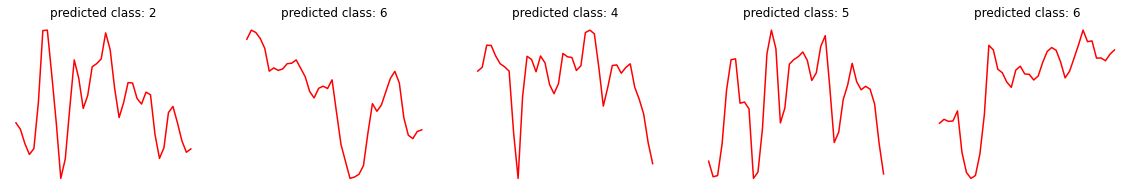

In [5]:
#@title Show some examples from the MNIST 1-D dataset

plt.figure(figsize=(20,3))

plt.subplot(151)
plt.plot(dataset['x'][0], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][0]))

plt.subplot(152)
plt.plot(dataset['x'][1], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][1]))

plt.subplot(153)
plt.plot(dataset['x'][2], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][2]))

plt.subplot(154)
plt.plot(dataset['x'][3], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][3]))

plt.subplot(155)
plt.plot(dataset['x'][4], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][4]))

Text(0.5, 1.0, 'predicted class: 9')

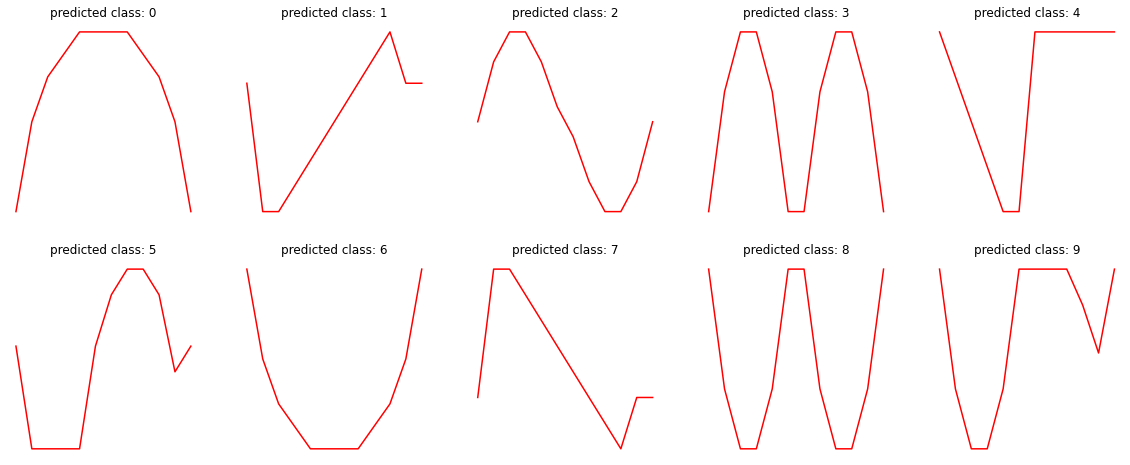

In [6]:
#@title Show the digit templates in the MNIST 1-D dataset 

plt.figure(figsize=(20,8))

plt.subplot(251)
plt.plot(dataset['templates']['x'][0], 'r')
plt.axis('off')
plt.title('predicted class: 0')

plt.subplot(252)
plt.plot(dataset['templates']['x'][1], 'r')
plt.axis('off')
plt.title('predicted class: 1')

plt.subplot(253)
plt.plot(dataset['templates']['x'][2], 'r')
plt.axis('off')
plt.title('predicted class: 2')

plt.subplot(254)
plt.plot(dataset['templates']['x'][3], 'r')
plt.axis('off')
plt.title('predicted class: 3')

plt.subplot(255)
plt.plot(dataset['templates']['x'][4], 'r')
plt.axis('off')
plt.title('predicted class: 4')

plt.subplot(256)
plt.plot(dataset['templates']['x'][5], 'r')
plt.axis('off')
plt.title('predicted class: 5')

plt.subplot(257)
plt.plot(dataset['templates']['x'][6], 'r')
plt.axis('off')
plt.title('predicted class: 6')

plt.subplot(258)
plt.plot(dataset['templates']['x'][7], 'r')
plt.axis('off')
plt.title('predicted class: 7')

plt.subplot(259)
plt.plot(dataset['templates']['x'][8], 'r')
plt.axis('off')
plt.title('predicted class: 8')

plt.subplot(2,5,10)
plt.plot(dataset['templates']['x'][9], 'r')
plt.axis('off')
plt.title('predicted class: 9')

Saving the dataset

In [7]:
f = open("MNIST1D.pkl","wb")
pickle.dump(dataset,f)
f.close()

# Model Creation

**Creating model :**

A 1-Dimensional CNN, containing 3 convolutional layers, followed by a fully-connected output layer.

In [8]:
##Task1-Question1
weight_decay = 5e-4
model = Sequential()

#Your code starts from here 

num_classes = 10
model.add(Conv1D(filters=25, kernel_size=5, strides=1, activation='relu', padding='same', 
                 kernel_regularizer=regularizers.l2(weight_decay), 
                 input_shape=(40, 1))) 
                 #40 'timesteps' in each dataset, 10 classes/features, 1 layer ('greyscale')
model.add(Conv1D(filters=25, kernel_size=3, strides=1, activation='relu', padding='same', 
                 kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv1D(filters=25, kernel_size=3, strides=1, activation='relu', padding='same', 
                 kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(weight_decay)))

print(model.summary())


##

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 25)            150       
                                                                 
 conv1d_1 (Conv1D)           (None, 40, 25)            1900      
                                                                 
 conv1d_2 (Conv1D)           (None, 40, 25)            1900      
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 10)                10010     
                                                                 
Total params: 13,960
Trainable params: 13,960
Non-trainable params: 0
_________________________________________________________________
None


# Training the model

Compiling the model

Loss function: Cross-entropy

Optimizer: Stochastic Gradient Descent (SGD) (learning rate = 0.01)

Tensorboard: For recording the training procedure

In [10]:
##Task1-Question2

#Your code 

model.compile(optimizer='sgd', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy']) #sparse categorial chosen to use integer labels

fit_output = model.fit(x=np.expand_dims(dataset['x'], axis=-1), y=dataset['y'], validation_split=0.1, epochs=200)

history = fit_output.history
#pickle history
with open('log/train/mnist_history.pkl', 'wb') as f:
    pickle.dump(history, f)
model.save('MNIST1D.h5')
##

Epoch 1/200
113/113 [==============================] - 1s 9ms/step - loss: 0.1181 - accuracy: 1.0000 - val_loss: 0.5115 - val_accuracy: 0.8900
Epoch 2/200
113/113 [==============================] - 1s 5ms/step - loss: 0.1181 - accuracy: 0.9994 - val_loss: 0.5024 - val_accuracy: 0.8925
Epoch 3/200
113/113 [==============================] - 1s 5ms/step - loss: 0.1178 - accuracy: 0.9997 - val_loss: 0.5048 - val_accuracy: 0.8900
Epoch 4/200
113/113 [==============================] - 1s 5ms/step - loss: 0.1167 - accuracy: 1.0000 - val_loss: 0.4990 - val_accuracy: 0.8850
Epoch 5/200
113/113 [==============================] - 1s 6ms/step - loss: 0.1174 - accuracy: 1.0000 - val_loss: 0.4960 - val_accuracy: 0.8875
Epoch 6/200
113/113 [==============================] - 1s 5ms/step - loss: 0.1171 - accuracy: 0.9997 - val_loss: 0.5141 - val_accuracy: 0.8775
Epoch 7/200
113/113 [==============================] - 1s 5ms/step - loss: 0.1170 - accuracy: 0.9997 - val_loss: 0.4942 - val_accuracy: 0.8850

# Plotting the training progress

Overall
32/32 [==============================] - 0s 4ms/step - loss: 0.4803 - accuracy: 0.9050
0
4/4 [==============================] - 0s 8ms/step - loss: 0.1139 - accuracy: 1.0000
1
4/4 [==============================] - 0s 3ms/step - loss: 0.4205 - accuracy: 0.9231
2
3/3 [==============================] - 0s 5ms/step - loss: 0.8929 - accuracy: 0.8427
3
4/4 [==============================] - 0s 3ms/step - loss: 0.1426 - accuracy: 0.9717
4
4/4 [==============================] - 0s 3ms/step - loss: 0.6014 - accuracy: 0.8962
5
4/4 [==============================] - 0s 4ms/step - loss: 0.5866 - accuracy: 0.8571
6
4/4 [==============================] - 0s 3ms/step - loss: 0.4810 - accuracy: 0.9293
7
3/3 [==============================] - 0s 3ms/step - loss: 0.5648 - accuracy: 0.8542
8
4/4 [==============================] - 0s 3ms/step - loss: 0.2868 - accuracy: 0.9694
9
4/4 [==============================] - 0s 5ms/step - loss: 0.7768 - accuracy: 0.7941


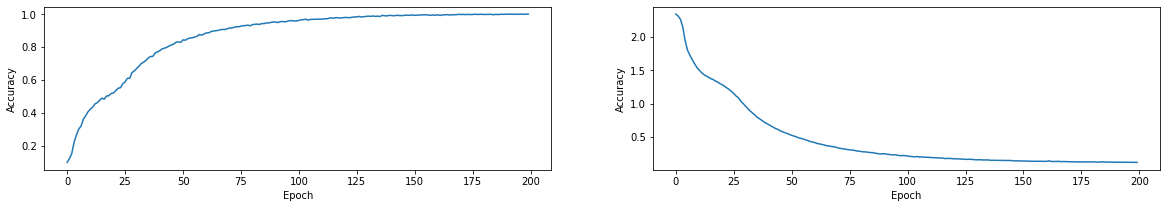

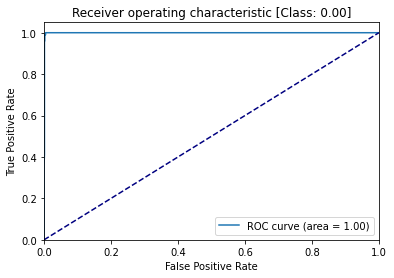

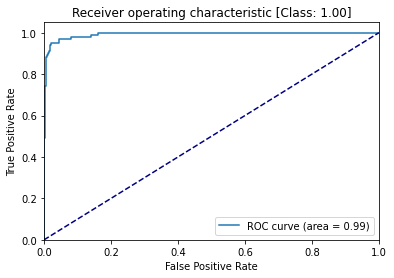

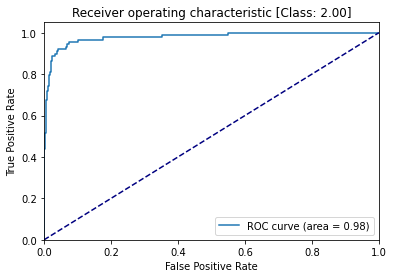

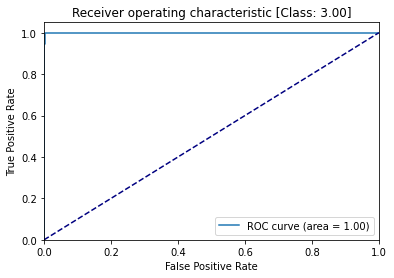

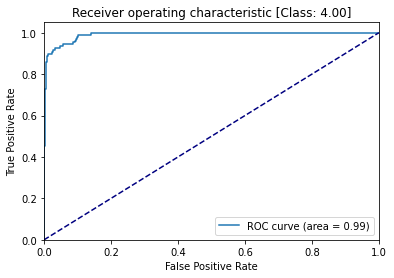

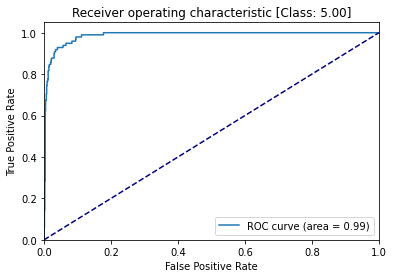

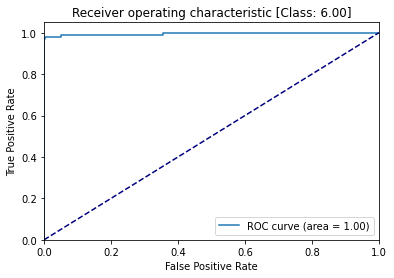

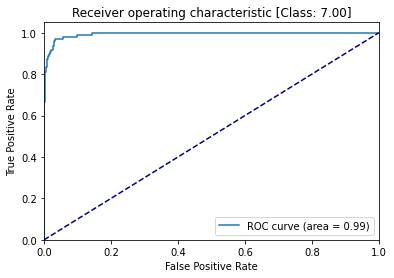

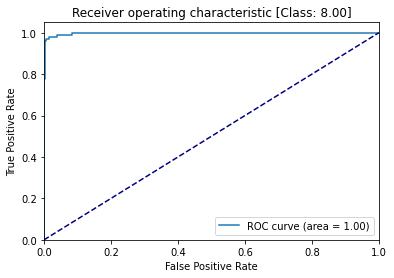

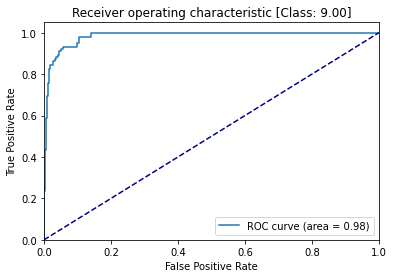

Class: 0
Precision: 1.0
Recall: 0.9622641509433962
F1: 0.9807692307692307

Class: 1
Precision: 0.9230769230769231
Recall: 0.8888888888888888
F1: 0.9056603773584906

Class: 2
Precision: 0.8426966292134831
Recall: 0.7978723404255319
F1: 0.8196721311475411

Class: 3
Precision: 0.9716981132075472
Recall: 0.9809523809523809
F1: 0.976303317535545

Class: 4
Precision: 0.8962264150943396
Recall: 0.8962264150943396
F1: 0.8962264150943396

Class: 5
Precision: 0.8571428571428571
Recall: 0.8155339805825242
F1: 0.835820895522388

Class: 6
Precision: 0.9292929292929293
Recall: 0.989247311827957
F1: 0.9583333333333333

Class: 7
Precision: 0.8541666666666666
Recall: 0.9010989010989011
F1: 0.8770053475935828

Class: 8
Precision: 0.9693877551020408
Recall: 0.95
F1: 0.9595959595959594

Class: 9
Precision: 0.7941176470588235
Recall: 0.8617021276595744
F1: 0.8265306122448979

Macro Precision: 0.9037805935855611
Macro Recall: 0.9043786497473494
Macro F1: 0.9035917620195308


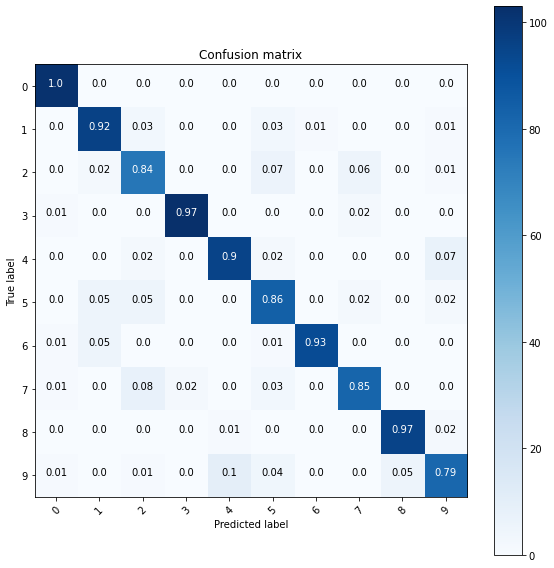

In [18]:
##Task1-Question3.a

#Your code

plt.figure(figsize=(20,3))

plt.subplot(121)
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.subplot(122)
plt.plot(history.history['loss'], label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

#overall
print('Overall')
model.evaluate(x=np.expand_dims(dataset['x_test'], axis=-1), y=dataset['y_test'])

#classwise

fpr = dict()
tpr = dict()
roc_auc = dict()

for idx in range(0, 10):
    print(idx)
    
    idx_dataset = dict()
    idx_dataset['x'] = []
    idx_dataset['y'] = []
    for c_idx in range(0, dataset['x_test'].shape[0]):
        if dataset['y_test'][c_idx] == idx:
            idx_dataset['x'].append(dataset['x_test'][c_idx])
            idx_dataset['y'].append(dataset['y_test'][c_idx])
    idx_dataset['x'] = np.asarray(idx_dataset['x'])
    idx_dataset['y'] = np.asarray(idx_dataset['y'])
    
    model.evaluate(x=np.expand_dims(idx_dataset['x'], axis=-1), y=idx_dataset['y'])

# roc, auc

plt.figure()

# one-hot encode the classes
y_test = preproc.label_binarize(dataset['y_test'], classes=dataset['templates']['y']) 

# make predictions (for roc/auc AND normalized confusion matrix)
y_score = model.predict(x=np.expand_dims(dataset['x_test'], axis=-1))
y_pred = np.argmax(y_score, axis=1)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(dataset['templates']['y'].shape[0]):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    
    plt.plot(fpr[i], tpr[i], label="ROC curve (area = %0.2f)" % roc_auc[i])
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic [Class: %0.2f]" % i)
    plt.legend(loc="lower right")
    plt.show()
    
# normalized confusion matrix

cm = tensorflow.math.confusion_matrix(dataset['y_test'], y_pred, num_classes=10).numpy()
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

figure = plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Normalize the confusion matrix.
cm_n = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

# Use white text if squares are dark; otherwise black.
threshold = cm_n.max() / 2.

for i, j in itertools.product(range(cm_n.shape[0]), range(cm_n.shape[1])):
    color = "white" if cm_n[i, j] > threshold else "black"
    plt.text(j, i, cm_n[i, j], horizontalalignment="center", color=color)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Precision/Recall/F-1
precision = []
recall = []
f_1 = []
for i in range(dataset['templates']['y'].shape[0]):
    precision.append(float(cm[i, i])/float(sum(cm[i, :])))
    recall.append(float(cm[i, i])/float(sum(cm[:, i])))
    f_1.append(2*precision[i]*recall[i]/(precision[i] + recall[i]))
    print(f'Class: {i}')
    print(f'Precision: {precision[i]}')
    print(f'Recall: {recall[i]}')
    print(f'F1: {f_1[i]}')
    print()
    
print(f'Macro Precision: {sum(precision)/len(precision)}')
print(f'Macro Recall: {sum(recall)/len(recall)}')
print(f'Macro F1: {sum(f_1)/len(f_1)}')

##

Struggles the most with 5 and 9

 - very similar symbols

# Explanation

In [20]:
from xai_utils import *

Take a test sample

In [21]:
x_test = dataset['x_test']
y_test = dataset['y_test']

Give the input to the model (Prediction)

In [29]:
index = int(np.floor(np.random.rand()*1000))
sise_input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
smoothgrad_input = x_test[index]
print(smoothgrad_input)
label = y_test[index]
print('Correct digit: '+str(label))
print('Predicted digit: '+str(np.argmax(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy())))
print('Confidence score for the correct label: '+str(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()[0,label]))

[-0.41964018 -0.55847576 -0.18657848 -0.15406608  0.65579544  1.4360174
  1.16084655  1.15492436  1.00211832  0.32857372 -0.49863892 -0.52542899
  0.31054767  0.53869151  0.15470595  0.10362162  0.05591021 -0.3528425
 -0.47846212 -0.5362061  -0.18612487  0.43254405  0.13786908  0.01945835
 -2.263661   -3.168496   -3.47387373 -3.53333721 -3.02475831 -1.62703274
 -0.32141155 -0.99643128 -1.77473361 -1.44326726 -0.12436397  0.66747411
  0.87126318  0.61890874  0.1294697  -0.01841724]
Correct digit: 6
Predicted digit: 6
Confidence score for the correct label: 0.9999999


## SISE (Semantic Input Sampling for Explanation)

In [23]:
explanation = SISE(sise_input, model, label, [['conv1d_2']], grad_thr=0.)

Text(0.5, 1.0, 'Highlighted input region (by the SISE algorithm)')

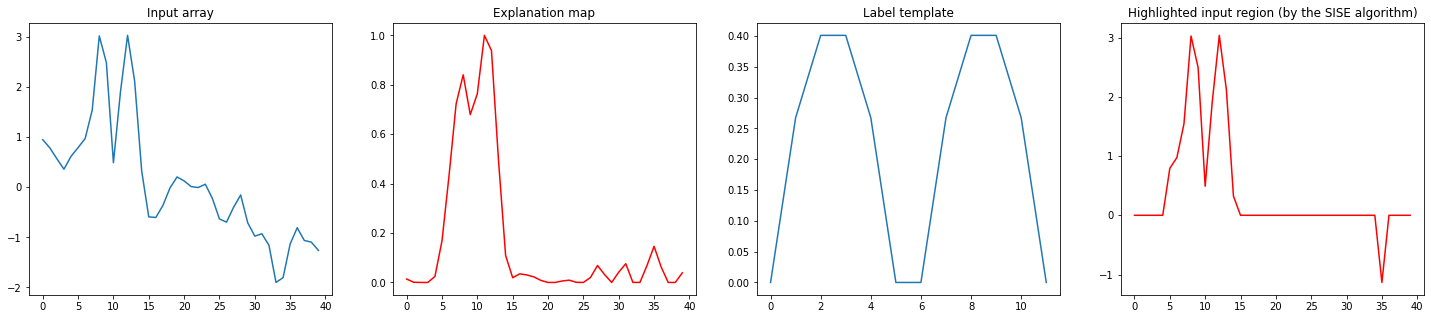

In [24]:
threshold = np.sort(explanation[:,0])[-12]

plt.figure(figsize=(25,5))

plt.subplot(1,4,1)
plt.plot(sise_input[0])
plt.title('Input array')

plt.subplot(1,4,2)
plt.plot(explanation, 'r')
plt.title('Explanation map')

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][label])
plt.title('Label template')

plt.subplot(1,4,4)
plt.plot((sise_input[0]*(explanation>threshold)), 'r')
plt.title('Highlighted input region (by the SISE algorithm)')

## SmoothGrad

Text(0.5, 1.0, 'Highlighted input region (by the SmoothGrad algorithm)')

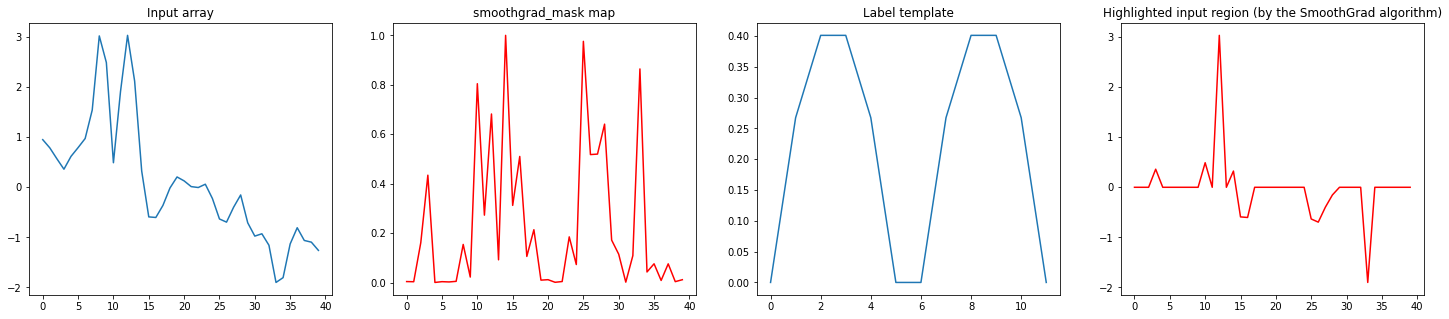

In [28]:
# primarily taken from the TF2 example from the Saliency library, though some (mainly formatting) modifications were required to run with the sequential model

gradient_saliency = saliency.GradientSaliency()

def call_model_function(images, call_model_args=None, expected_keys=None):
    target_class_idx =  call_model_args['class_idx']
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        if expected_keys==[saliency.base.INPUT_OUTPUT_GRADIENTS]:
            tape.watch(images)

            output_layer = model(images)
            output_layer = output_layer[:,target_class_idx]
            gradients = np.array(tape.gradient(output_layer, images))
            return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
        else:
            conv_layer, output_layer = model(images)
            gradients = np.array(tape.gradient(output_layer, conv_layer))
            return {saliency.base.CONVOLUTION_LAYER_VALUES: conv_layer,
                    saliency.base.CONVOLUTION_OUTPUT_GRADIENTS: gradients}
        
prediction_class = np.argmax(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy())

smoothgrad_exp = gradient_saliency.GetSmoothedMask(smoothgrad_input, call_model_function, {'class_idx': prediction_class}) #1D array output

# 'normalize' to 1 at peak

smoothgrad_exp = smoothgrad_exp/max(smoothgrad_exp)

smoothgrad_thresh = np.sort(smoothgrad_exp)[-12]

plt.figure(figsize=(25,5))

plt.subplot(1,4,1)
plt.plot(smoothgrad_input)
plt.title('Input array')

plt.subplot(1,4,2)
plt.plot(smoothgrad_exp, 'r')
plt.title('smoothgrad_mask map')

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][label])
plt.title('Label template')

plt.subplot(1,4,4)
plt.plot((smoothgrad_input*(smoothgrad_exp>smoothgrad_thresh)), 'r')
plt.title('Highlighted input region (by the SmoothGrad algorithm)')


## Quantitative evaluation

In [ ]:
def calculate_drop_increase(images, model, exmap, class_index, frac=0.15):
    '''
    inputs:
        images: a 4-D image of size (1 x H x W x 3)
          containing an image in RGB format and of size (H x W)
        model: The base model
        exmap: a given explanation map whose completeness is to be evaluated.
        class_index: The class to whom the explanation map is related to.
        frac: The fraction of top pixels selected.
    returns:v
        a tuple with 4 calculates values:
        (drop, increase, original_pred, eplanation_pred)
        drop (float): drop rate (between 0 and 1)
        increase (boolean): "1" if increase happened
        original_pred: confidence score for original image
        explanation_pred:  confidence score for the selected top pixels of the image.
    '''
    predictions = model.predict(images)
    #print(images.shape)
    # Pre-processing image 
    img=images[0,:,:]
    #img=img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Getting the prediction for image
    Y=predictions[0][class_index]
    
    grad_array=np.reshape(exmap, (-1,))
    array_size=int(grad_array.shape[0]*frac)
    thr=np.flip(sorted(grad_array))[array_size]
    exmap1_msk=(exmap>thr)
    exmap1_thr=np.zeros(shape=(1,40,1))
    exmap1_thr=img*exmap1_msk
    ex_predictions = model.predict(exmap1_thr)[0]
    O1=ex_predictions[class_index]
    etta=(Y-O1)/(Y+1e-100)
    return (etta*(etta>0), 1*(etta<0), Y, O1)

In [ ]:
drop_rate = 0.
for index in range(1000):
    prediction=model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()
    explanation_map = SISE(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, layers=[['conv1d_2']], class_index=np.argmax(prediction[0]), grad_thr=0.)
    drop_rate += calculate_drop_increase(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, explanation_map, class_index=np.argmax(prediction[0]), frac=0.3)[0]
drop_rate /= 1000